In [2]:
import pandas as pd
import numpy as np
import ta
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import gymnasium as gym
import math
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def create_subplots(n,df,st):
    fig, axes = plt.subplots(1, n, figsize=(7*n, 2*n))
    for i in range(n):
        data = df[i]['Open']
        axes[i].plot(data)
        axes[i].set_title(st[i][:-4])
    plt.show()
# n = len(dataframes)
# create_subplots(n,df=dataframes,st=stocks)

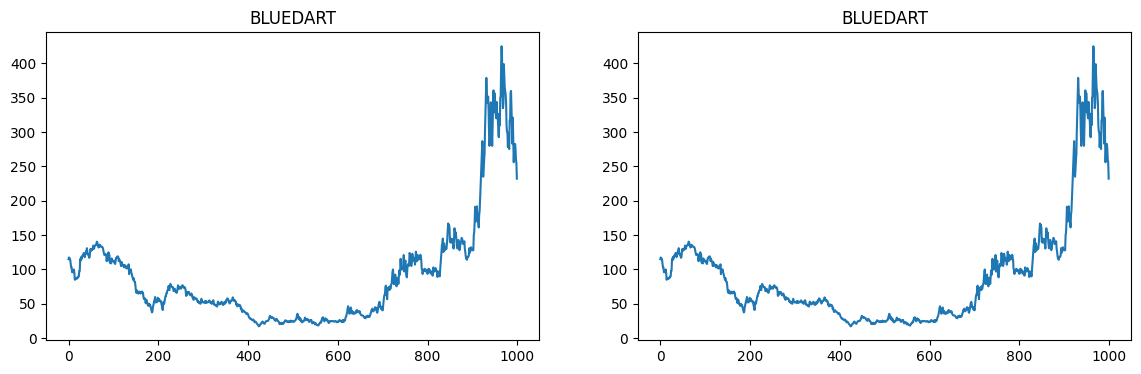

In [29]:

test_stocks=['BLUEDART.csv','BLUEDART.csv']


test_dataframes=[]
# stocks=['63MOONS.csv']
path='/home/siddharth/Desktop/MultiTrading/Datasets/SCRIP/'
timesteps=1000
for name in test_stocks:
    df=pd.read_csv(path+name)
    df=df[:timesteps]
    df=df[['Open','Close','High','Low','Volume']]
    df.reset_index(inplace=True,drop=True)
    test_dataframes.append(df)
create_subplots(n=2,df=test_dataframes,st=test_stocks)

In [30]:
import ta

def preprocess(data):
    long_sma_window = 50
    short_sma_window = 20
    data['feature_Long_SMA'] = data['Close'].rolling(window=long_sma_window, min_periods=1).mean()
    data['feature_Short_SMA'] = data['Close'].rolling(window=short_sma_window, min_periods=1).mean()
    data['feature_RSI'] = ta.momentum.rsi(close=data['Close'], window=14)
    data["feature_Close"] = data["Close"].pct_change()
    data["feature_Open"] = data["Open"]/data["Close"]
    data["feature_High"] = data["High"]/data["Close"]
    data["feature_Low"] = data["Low"]/data["Close"]
    data['feature_MACD'] = ta.trend.macd(data["Close"])
    data['feature_CCI'] = ta.trend.cci(data["High"], data["Low"], data["Close"], window=20)
    data['feature_BB_upper'], data['feature_BB_middle'], data['feature_BB_lower'] = ta.volatility.bollinger_hband(data["Close"]), ta.volatility.bollinger_mavg(data["Close"]), ta.volatility.bollinger_lband(data["Close"])
    data['feature_Slowk']= ta.momentum.stoch(data["High"], data["Low"], data["Close"])
    data['feature_ATR'] = ta.volatility.average_true_range(data["High"], data["Low"], data["Close"], window=14)
    data.dropna(inplace=True)
    data.reset_index(inplace=True, drop=True)


In [31]:

import itertools
num_stocks=len(test_dataframes)
boxes=2*num_stocks
rng = list(range(boxes + 1)) * num_stocks
wt_combs=[]
lol=set(i for i in itertools.permutations(rng, num_stocks) if sum(i) == boxes)
for i in lol:
    wt_combs.append(i)
wt_combs=np.array(wt_combs)
wt_combs_norm=wt_combs/boxes
print(len(wt_combs_norm))


5


In [32]:
norm_test_dataframes=[]
for i in range(len(test_dataframes)):
    df=test_dataframes[i]
    preprocess(df)
    test_dataframes[i]=df
    df = (df - df.min()) / (df.max() - df.min())
    norm_test_dataframes.append(df)


In [33]:
from Env import MultiTradingEnv;
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Testing_arr = []
LOOKBACK=5
step=0.25
positions=np.arange(0,1,step)
positions=np.append(positions,1)
Test_Env = MultiTradingEnv(dataframes_array=test_dataframes,
                    norm_dataframes=norm_test_dataframes,
                    total_timesteps=len(test_dataframes[0])-LOOKBACK-1,
                    initial_cap=100000.0,
                    features=['feature_RSI','feature_Close','feature_MACD','feature_CCI','feature_Slowk','feature_ATR'],
                    lookback=LOOKBACK,
                    positions=positions,
                    wt_combs=wt_combs_norm,
                    )
state=Test_Env.reset()

n_observations = len(state.features.flatten())
print(n_observations)

import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = F.selu(self.layer1(x))
        x = F.selu(self.layer2(x))
        x = F.selu(self.layer3(x))
        # Reshape the output to have shape (batch_size, 3, 10)
        x = self.layer4(x).view(-1, len(Test_Env.positions),Test_Env.num_stocks)
        return x

class DQNW(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQNW, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = F.selu(self.layer1(x))
        x = F.selu(self.layer2(x))
        x = F.selu(self.layer3(x))
        x = self.layer4(x).view(-1, len(wt_combs_norm))
        return x


60


In [34]:
tmp=np.zeros(shape=len(Test_Env.dataframes_array[0]))
cnt=0
wts=np.ones(num_stocks)/num_stocks
for i in Test_Env.dataframes_array:
    num=(100000*wts[cnt])/np.array(i['Open'][0])
    ar=np.array(i['Open'])*num
    tmp+=ar
    cnt+=1
tmp=tmp[5:-15]
tmp/=tmp[0]
tmp*=100000

In [39]:
end=81
Testing_arr=[]
ep_step=10
for i in range (80,end,ep_step):
    st=set()
    st2=set()
    prev1=()
    prev2=()
    cnt1=0
    cnt2=0
    Test_Env = MultiTradingEnv(dataframes_array=test_dataframes,
                      norm_dataframes=norm_test_dataframes,
                       total_timesteps=len(test_dataframes[0])-LOOKBACK-1,
                       initial_cap=100000.0,
                       features=['feature_RSI','feature_Close','feature_MACD','feature_CCI','feature_Slowk','feature_ATR'],
                       lookback=LOOKBACK,
                       positions=positions,
                       wt_combs=wt_combs_norm,
                       )
    n_actions = Test_Env.num_stocks*len(Test_Env.positions)
    n_weights=len(wt_combs_norm)
    state = Test_Env.reset()
    n_observations = len(state.features.flatten())
    policy_net = DQN(n_observations, n_actions).to(device)
    policy_net_wt=DQNW(n_observations,n_actions).to(device)
    policy_net=torch.load(f'/home/siddharth/Downloads/model_{i}.pth',map_location=torch.device('cpu'))
    policy_net_wt=torch.load(f'/home/siddharth/Downloads/model_wt_{i}.pth',map_location=torch.device('cpu'))
    policy_net.eval()
    policy_net_wt.eval()


    state= Test_Env.reset()
    state = torch.tensor(state.features, dtype=torch.float32, device=device).unsqueeze(0)
    while(1):
        Action = policy_net(state.view(-1)).max(1).indices.to(device)
        weight = policy_net_wt(state.view(-1)).max(1).indices.to(device)
        if(tuple((Action.tolist()[0]))!=prev1):
            cnt1+=1
            prev1=tuple((Action.tolist()[0]))
        if(tuple(wt_combs_norm[weight].tolist())!=prev2):
            cnt2+=1
            prev2=tuple(wt_combs_norm[weight].tolist())
        st.add(tuple(wt_combs_norm[weight].tolist()))
        # print(Action)
        st2.add(tuple(Action.tolist()[0]))
        observation, reward, terminated  = Test_Env.step(Action,weight)
        # reward = torch.tensor([reward], device=device)
        # print(reward)
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation.features, dtype=torch.float32, device=device).unsqueeze(0)
        if terminated:
            break
        Test_Env.render(episode_num=0,reward=reward)
    print((st),st2,cnt1,cnt2)
    Testing_arr.append(Test_Env.history_array_episode)

{(0.25, 0.75)} {(0, 2)} 1 1


Sortino Ratio: 0.06722732177340722
Sharpe Ratio: -0.9215914148446389
Maximum Drawdown: 0.5066670566219835


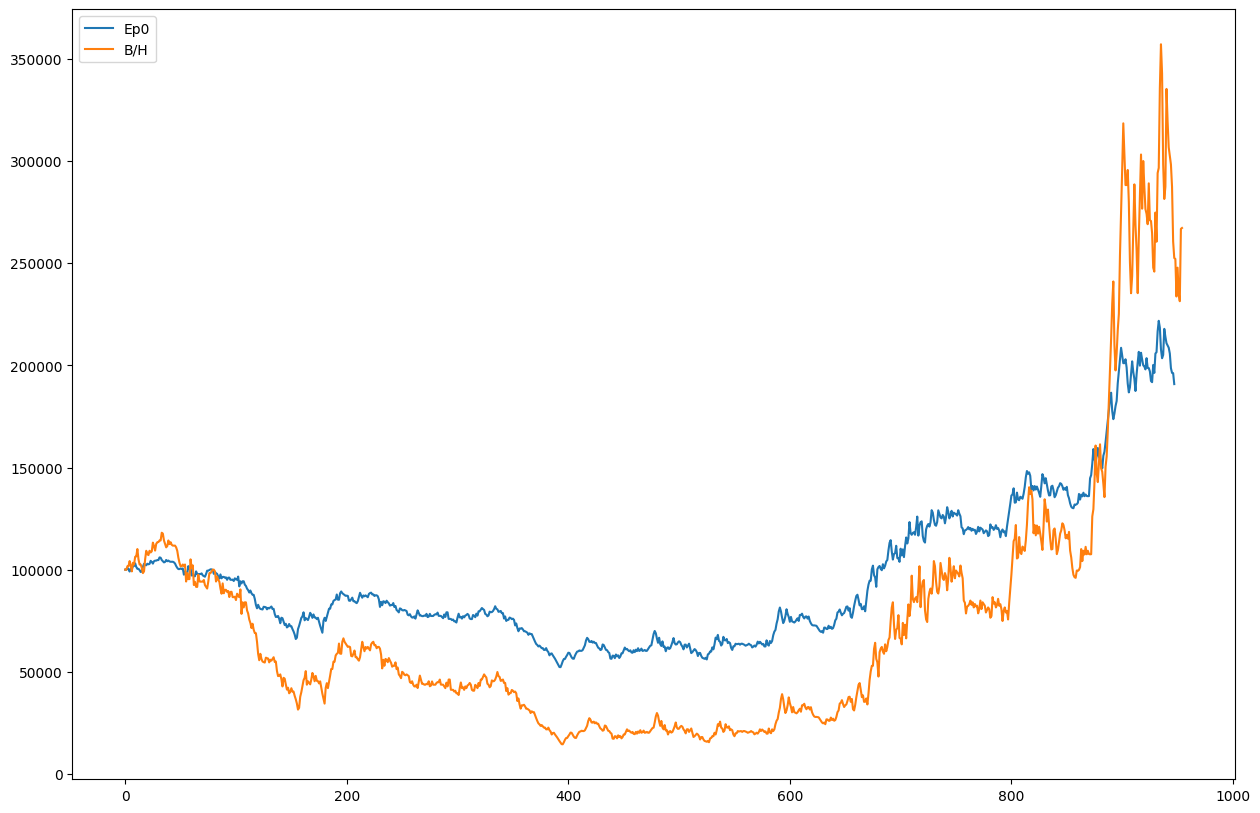

In [40]:
import numpy as np

# Define a function to calculate Sortino Ratio
def sortino_ratio(returns, target_return=0):
    downside_returns = np.minimum(returns - target_return, 0)
    downside_deviation = np.sqrt(np.mean(np.square(downside_returns)))
    average_return = np.mean(returns)
    sortino_ratio = average_return / downside_deviation
    return sortino_ratio
def sharpe_ratio(returns, risk_free_rate=0.02):
    average_return = np.mean(returns)
    std_deviation = np.std(returns)
    sharpe_ratio = (average_return - risk_free_rate) / std_deviation
    return sharpe_ratio
def max_drawdown(prices):
    max_drawdown = 0
    peak = prices[0]
    for price in prices:
        if price > peak:
            peak = price
        drawdown = (peak - price) / peak
        max_drawdown = max(max_drawdown, drawdown)
    return max_drawdown
plt.figure(figsize=(15, 10))
for j in range(0,len(Testing_arr)):
  stock_prices = [Testing_arr[j][i][3] for i in range(len(Testing_arr[j]))]
  stock_returns = np.diff(stock_prices) / stock_prices[:-1]
  sortino = sortino_ratio(stock_returns)
  sharpe= sharpe_ratio(stock_returns)
  maxd=max_drawdown(stock_prices)
  print("Sortino Ratio:", sortino)
  print("Sharpe Ratio:", sharpe)
  print("Maximum Drawdown:", maxd)
  plt.plot([Testing_arr[j][i][3] for i in range(len(Testing_arr[j]))],label=f'Ep{j*ep_step}')
  np.save('DQN.npy',[Testing_arr[j][i][3] for i in range(len(Testing_arr[j]))])
plt.plot(tmp,label='B/H')
plt.legend()


In [ ]:
import pandas_ta as ta

EARNING: $30479.2 ; ROI: 121.92%
EARNING: $703.6 ; ROI: 2.81%
EARNING: $-2347.05 ; ROI: -9.39%
EARNING: $3068.2 ; ROI: 12.27%


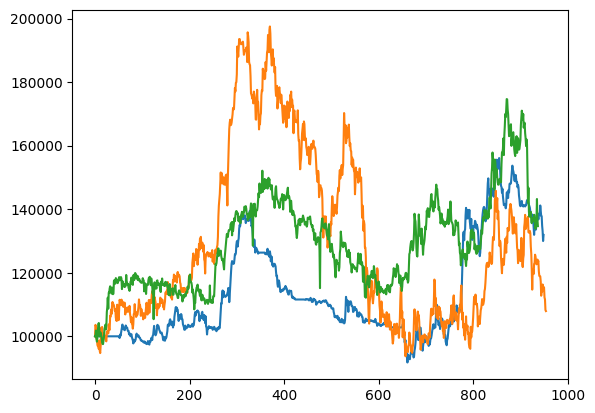

In [ ]:
import numpy as np
import math

class Donchian:
    def __init__(self, stock_array, investment, timesteps):
        self.stock_array = stock_array
        self.investment = investment/len(self.stock_array)
        self.timesteps = timesteps
        self.net_worth = np.zeros(timesteps)
        
        
    def stratergy(self):
      for i in range(len(self.stock_array)):
        self.stock_array[i][['dcl', 'dcm', 'dcu']] = self.stock_array[i].ta.donchian(lower_length = 40, upper_length = 50)

    def implement_strategy(self):
        for aapl in self.stock_array:
            in_position = False
            equity = self.investment
            no_of_shares = 0
            self.net_worth[0] += self.investment
            for i in range(1, self.timesteps):
                if aapl['High'][i] == aapl['dcu'][i] and not in_position:
                    no_of_shares = math.floor(equity / aapl.Close[i])
                    equity -= (no_of_shares * aapl.Close[i])
                    in_position = True
                    self.net_worth[i] += (equity + no_of_shares * aapl.Close[i])
                elif aapl['Low'][i] == aapl['dcl'][i] and in_position:
                    equity += (no_of_shares * aapl.Close[i])
                    no_of_shares = 0
                    self.net_worth[i] += (equity + (no_of_shares * aapl.Close[i]))
                    in_position = False
                else:
                    self.net_worth[i] += (equity + (no_of_shares * aapl.Close[i]))
            if in_position:
                equity += (no_of_shares * aapl.Close[i])
                in_position = False

            earning = round(equity - self.investment, 2)
            roi = round(earning / self.investment * 100, 2)
            print(f'EARNING: ${earning} ; ROI: {roi}%')
        return self.net_worth


timesteps = 950
investment = 100000
final_portfolio_networth = np.zeros(timesteps)
stock_array = test_dataframes

strategy1 = Donchian(stock_array, investment, timesteps)
strategy1.stratergy()
net_worth = strategy1.implement_strategy()
plt.plot(net_worth)
plt.plot(tmp)
plt.plot([Testing_arr[8][i][3] for i in range(len(Testing_arr[8]))],label=f'Ep{j*ep_step}')
